In [437]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
import embedders
import numpy as np
import torch
import matplotlib.pyplot as plt

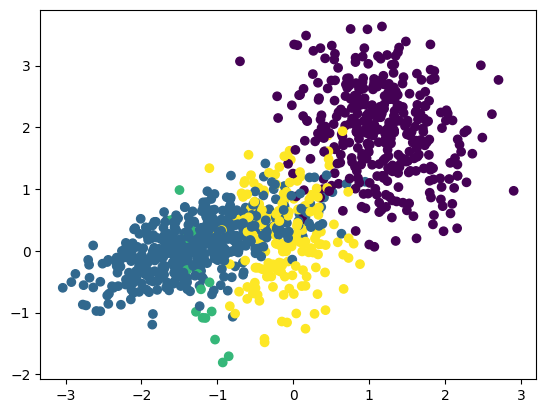

In [475]:
pm = embedders.manifolds.ProductManifold(signature=[(0, 2)])
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, num_classes=4, cov_scale_points=1e-1)#, task="regression")

X_np = X.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()

plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np)

tensor(3295.4590)


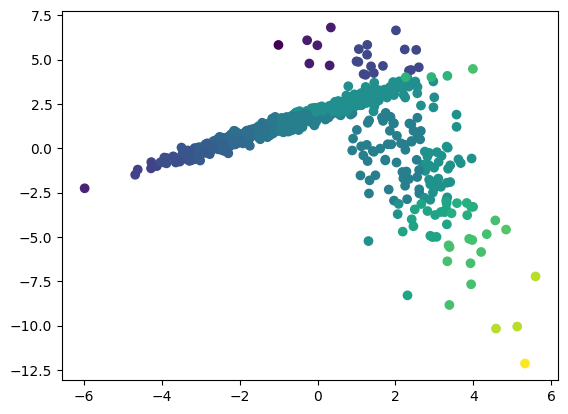

In [341]:
pdt = embedders.tree_new.ProductSpaceDT(pm=pm, task="regression", max_depth=5)
pdt.fit(X, y)

print(pdt.score(X, y))

y_pred_pdt = pdt.predict(X)
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_pred_pdt.detach().cpu().numpy())

0.8117547822563576


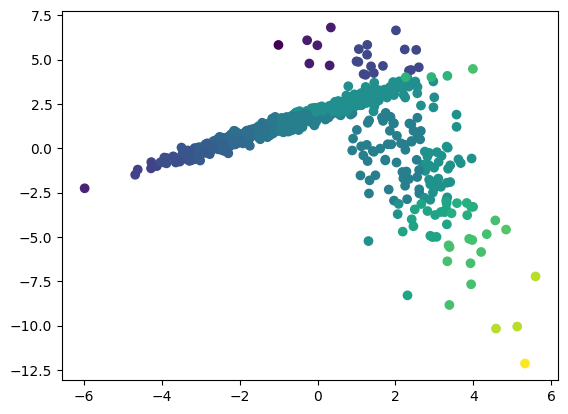

In [342]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_np, y_np)

y_pred = dt.predict(X_np)
print(dt.score(X_np, y_np))
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_pred)

In [66]:
# Let's collect all of our intermediate variables

X, y, _, comparisons = pdt._preprocess(X, y)

In [309]:
# Let's go step-by-step through the information gain computations to ensure they match

# pos_sums like in line 72 of new_tree.py
pos_sums = comparisons @ y
neg_sums = (1 - comparisons) @ y
n_pos = comparisons.sum(dim=-1) + 1e-10
n_neg = (1 - comparisons).sum(dim=-1) + 1e-10
pos_means = pos_sums / n_pos
neg_means = neg_sums / n_neg
all_means = y.mean()

# MSE component - line 85 onwards
pos_se = ((y[:, None, None] - pos_means) ** 2).permute(1, 2, 0)
neg_se = ((y[:, None, None] - neg_means) ** 2).permute(1, 2, 0)
pos_mse = (comparisons * pos_se).sum(dim=-1) / n_pos
neg_mse = ((1 - comparisons) * neg_se).sum(dim=-1) / n_neg
# pos_mse = torch.einsum("ijk,kj->ij", comparisons, pos_se) / n_pos
# neg_mse = torch.einsum("ijk,kj->ij", (1 - comparisons), neg_se) / n_neg
total_mse = (y - all_means) ** 2

# These variables will be sanity checks
pos_sums_check = torch.zeros_like(pos_sums)
pos_counts_check = torch.zeros_like(pos_sums)
neg_sums_check = torch.zeros_like(neg_sums)
neg_counts_check = torch.zeros_like(neg_sums)

# Also aggregate means into this
pos_means_check = torch.zeros_like(pos_sums)
neg_means_check = torch.zeros_like(neg_sums)

# And MSEs here
pos_se_check = torch.zeros_like(comparisons)
neg_se_check = torch.zeros_like(comparisons)
pos_mse_check = torch.zeros_like(pos_mse)
neg_mse_check = torch.zeros_like(neg_mse)

# Big expensive loop to check the sums
for i in range(comparisons.shape[0]):
    for j in range(comparisons.shape[1]):
        pos_vals = []
        neg_vals = []
        for k in range(comparisons.shape[2]):
            if comparisons[i, j, k]:
                pos_sums_check[i, j] += y[k]
                pos_counts_check[i, j] += 1
                pos_vals.append(y[k])
            else:
                neg_sums_check[i, j] += y[k]
                neg_counts_check[i, j] += 1
                neg_vals.append(y[k])

        # Check that the counts match
        assert len(pos_vals) == n_pos[i, j] - 1e-10
        assert len(neg_vals) == n_neg[i, j] - 1e-10

        # Store means - prevent nans by explicitly specifying "else 0" here
        pos_mean = torch.mean(torch.tensor(pos_vals)) if pos_vals else 0
        neg_mean = torch.mean(torch.tensor(neg_vals)) if neg_vals else 0
        pos_means_check[i, j] = pos_mean
        neg_means_check[i, j] = neg_mean

        # MSEs
        for k in range(y.shape[0]):
            pos_se_check[i, j, k] = (y[k] - pos_mean) ** 2 if pos_vals else 0
            neg_se_check[i, j, k] = (y[k] - neg_mean) ** 2 if neg_vals else 0
        # pos_mse_check[i, j] = torch.tensor(pos_vals).var() if len(pos_vals) > 1 else 0
        # neg_mse_check[i, j] = torch.tensor(neg_vals).var() if len(neg_vals) > 1 else 0
        pos_mse_check[i, j] = torch.mean((torch.tensor(pos_vals) - pos_mean) ** 2) if pos_vals else 0
        neg_mse_check[i, j] = torch.mean((torch.tensor(neg_vals) - neg_mean) ** 2) if neg_vals else 0

assert torch.allclose(pos_sums, pos_sums_check)
assert torch.allclose(neg_sums, neg_sums_check)
assert torch.allclose(n_pos, pos_counts_check)
assert torch.allclose(n_neg, neg_counts_check)
assert torch.allclose(pos_means, pos_means_check)
assert torch.allclose(neg_means, neg_means_check)
assert torch.allclose(pos_se, pos_se_check, atol=1e-4)
# assert torch.allclose(neg_se, neg_se_check, atol=1e-4) # Skip this check cause it fails when n_neg = 0
assert torch.allclose(pos_mse, pos_mse_check)
assert torch.allclose(neg_mse, neg_mse_check)

/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


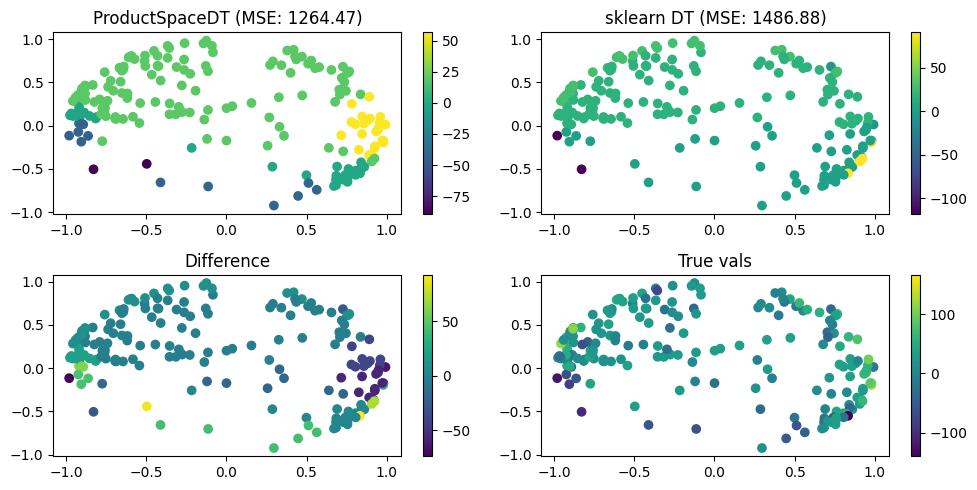

In [436]:
# Ok, something is still odd here. Maybe it has to do with train-test splits? Let's check that

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

DEPTH = 3

pm = embedders.manifolds.ProductManifold(signature=[(-1, 2)])
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, task="regression", num_clusters=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_np = X_train.detach().cpu().numpy()
X_test_np = X_test.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

pdt = embedders.tree_new.ProductSpaceDT(pm=pm, task="regression", max_depth=DEPTH)
pdt.fit(X_train, y_train)
pdt_ypred = pdt.predict(X_test).detach().cpu().numpy()
pdt_score = mean_squared_error(y_test_np, pdt_ypred)

dt = DecisionTreeRegressor(max_depth=DEPTH)
dt.fit(X_train_np, y_train_np)
dt_ypred = dt.predict(X_test_np)
dt_score = mean_squared_error(y_test_np, dt_ypred)

# Redo X_test_np as poincare disk
X_test_np = embedders.visualization.hyperboloid_to_poincare(X_test).detach().cpu().numpy()

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.colorbar(axs[0, 0].scatter(X_test_np[:, 0], X_test_np[:, 1], c=pdt_ypred), ax=axs[0, 0])
axs[0, 0].set_title(f"ProductSpaceDT (MSE: {pdt_score:.2f})")
fig.colorbar(axs[0, 1].scatter(X_test_np[:, 0], X_test_np[:, 1], c=dt_ypred), ax=axs[0, 1])
axs[0, 1].set_title(f"sklearn DT (MSE: {dt_score:.2f})")
fig.colorbar(axs[1, 0].scatter(X_test_np[:, 0], X_test_np[:, 1], c=dt_ypred - pdt_ypred.flatten()), ax=axs[1, 0])
axs[1, 0].set_title("Difference")
fig.colorbar(axs[1, 1].scatter(X_test_np[:, 0], X_test_np[:, 1], c=y_test_np), ax=axs[1, 1])
axs[1, 1].set_title("True vals")

# Colorbars
plt.tight_layout()
plt.show()